In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy import ndimage
import scipy.signal as sig
from scipy import misc
import imageio

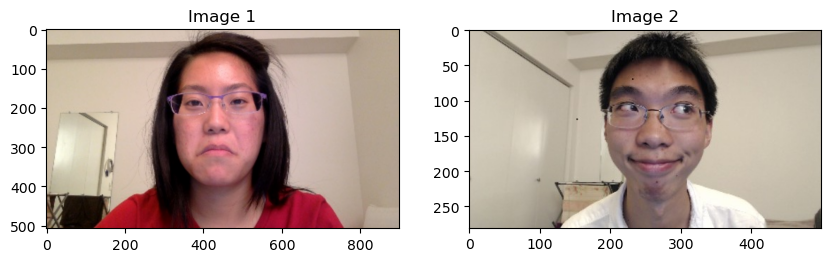

In [2]:
image1 = cv2.imread('./img1.png', cv2.IMREAD_COLOR)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('./img2.jpeg', cv2.IMREAD_COLOR)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# image1 = cv2.imread('./srihari_img/img1.jpg', cv2.IMREAD_COLOR)
# image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
# image2 = cv2.imread('./srihari_img/img2.jpg', cv2.IMREAD_COLOR)
# image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)



# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Image 2')

plt.show()

In [3]:
def detect_face_mouth(img, show=True):

    img_rgb = np.copy(img)
    # Load the pre-trained face cascade and mouth cascade
    face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
    mouth_cascade = cv2.CascadeClassifier('./haarcascade_mcs_mouth.xml')

    # Convert the image to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if any faces are detected
    if len(faces) > 0:
        # Get the largest detected face
        largest_face = max(faces, key=lambda rect: rect[2] * rect[3])

        # Draw a rectangle around the largest detected face
        x, y, w, h = largest_face
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Add extra margin to the bottom half of the face region
        margin = 50
        roi_face = gray[y + h // 2:y + h + margin, x:x + w]

        # Detect mouth within the extended face region
        mouth_rects = mouth_cascade.detectMultiScale(roi_face, scaleFactor=1.8, minNeighbors=15, minSize=(25, 15))

        # Check if a mouth is detected
        if len(mouth_rects) > 0:
            # Get the largest detected mouth region
            largest_mouth = max(mouth_rects, key=lambda rect: rect[2] * rect[3])

            # Expand the detected mouth region slightly
            x_mouth, y_mouth, w_mouth, h_mouth = largest_mouth
            expanded_mouth_rect = (x + x_mouth, y + h // 2 + y_mouth, w_mouth, h_mouth)

            if not show:
                x, y, w, h = expanded_mouth_rect[0], expanded_mouth_rect[1], expanded_mouth_rect[2], expanded_mouth_rect[3]
                return [y, y + h, x, x + w]

            # Draw a rectangle around the largest detected mouth region
            cv2.rectangle(img_rgb, (expanded_mouth_rect[0], expanded_mouth_rect[1]),
                          (expanded_mouth_rect[0] + expanded_mouth_rect[2],
                           expanded_mouth_rect[1] + expanded_mouth_rect[3]),
                          (0, 255, 0), 2)
    return img_rgb


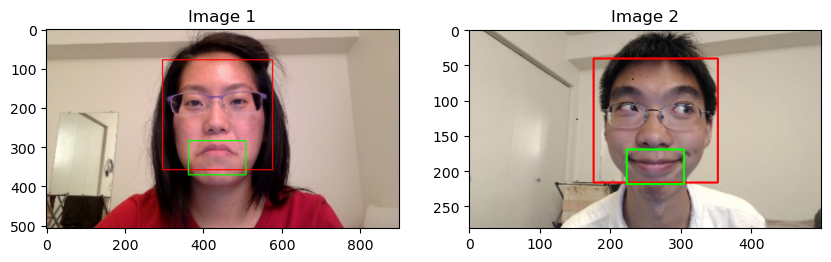

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(detect_face_mouth(image1))
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(detect_face_mouth(image2))
plt.title('Image 2')

plt.show()

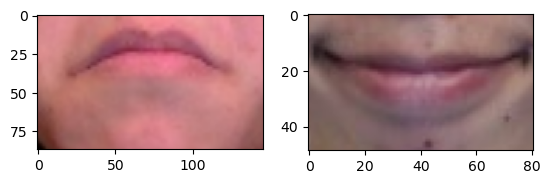

In [5]:
mouth1 = detect_face_mouth(image1,show=False)
mouth2 = detect_face_mouth(image2,show=False)
plt.subplot(1,2,1)
plt.imshow( image1[mouth1[0]:mouth1[1],mouth1[2]:mouth1[3]] );
plt.subplot(1,2,2)
plt.imshow(image2[mouth2[0]:mouth2[1],mouth2[2]:mouth2[3]]);

In [6]:
def swap_and_resize_mouths(image1, image2,mouth1,mouth2):
    # Detect mouths in the images
    mouth1 = detect_face_mouth(image1, show=False)
    mouth2 = detect_face_mouth(image2, show=False)

    # Extract mouth regions from the images
    mouth_region1 = image1[mouth1[0]:mouth1[1], mouth1[2]:mouth1[3]]
    mouth_region2 = image2[mouth2[0]:mouth2[1], mouth2[2]:mouth2[3]]

    # Resize mouths to fit the corresponding sizes
    resized_mouth1 = cv2.resize(mouth_region1, (mouth_region2.shape[1], mouth_region2.shape[0]))
    resized_mouth2 = cv2.resize(mouth_region2, (mouth_region1.shape[1], mouth_region1.shape[0]))

    # Swap and paste the resized mouths to the original images
    image1_copy = image1.copy()
    image1_copy[mouth1[0]:mouth1[1], mouth1[2]:mouth1[3]] = resized_mouth2

    image2_copy = image2.copy()
    image2_copy[mouth2[0]:mouth2[1], mouth2[2]:mouth2[3]] = resized_mouth1

    return image1_copy, image2_copy

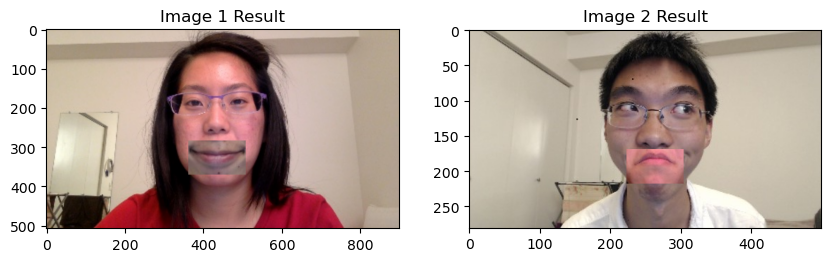

In [7]:
image1_result, image2_result = swap_and_resize_mouths(image1, image2,mouth1,mouth2)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1_result)
plt.title('Image 1 Result')

plt.subplot(1, 2, 2)
plt.imshow(image2_result)
plt.title('Image 2 Result')

plt.show()

In [8]:
def generate_mask(img,mouth):
    image = np.copy(img)
#     mouth_region = image[mouth[0]:mouth[1], mouth[2]:mouth[3]]
    y = mouth[0]
    h = mouth[1] - mouth[0]
    x = mouth[2]
    w = mouth[3] - mouth[2]
    
    mouth_region = image[y:y+h, x:x+w]

    # Create an empty black image of the same size as the original image
    mask = np.zeros_like(image)

    # Calculate the center and axes lengths for the ellipse
    center = ((x + x + w) // 2, (y + y + h) // 2)
    axes_lengths = (w // 2, h // 2)

    # Draw the ellipse on the mask
    cv2.ellipse(mask, center, axes_lengths, 0, 0, 360, (255, 255, 255), thickness=cv2.FILLED)
    
    return mask[:,:,0]

In [9]:
mask1 = generate_mask(image1,mouth1)
mask2 = generate_mask(image2,mouth2)

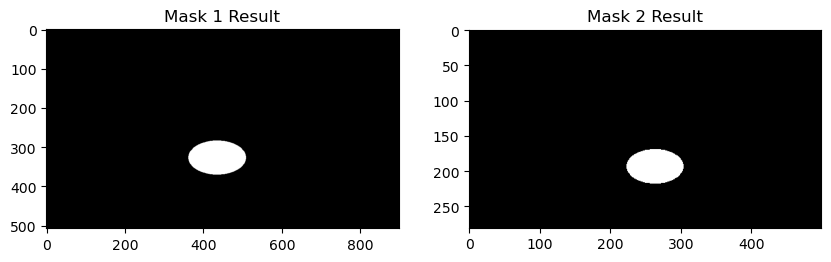

In [10]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask1,cmap = "gray")
plt.title('Mask 1 Result')

plt.subplot(1, 2, 2)
plt.imshow(mask2,cmap = "gray")
plt.title('Mask 2 Result')

plt.show()

In [11]:
def upsample(image, dst_shape):
  return cv2.pyrUp(image, dstsize=(dst_shape[1], dst_shape[0]))

def downsample(image):    
  cols = image.shape[1] // 2
  rows = image.shape[0] // 2                                             
  return cv2.pyrDown(image, dstsize=(cols, rows))    
                     
def pyramids(image):
  gaussian_pyramid = [image, ]
  laplacian_pyramid = []

  while image.shape[0] > 2 and image.shape[1] > 2:
    image = downsample(image)
    gaussian_pyramid.append(image)

  for i in range(len(gaussian_pyramid) - 1):
    laplacian_pyramid.append(gaussian_pyramid[i] - upsample(gaussian_pyramid[i + 1], gaussian_pyramid[i].shape))

  return gaussian_pyramid[:-1], laplacian_pyramid

def pyramidBlending(A, B, mask):
  _, source_LA = pyramids(A)
  _ ,dest_LB = pyramids(B)
  Gmask, _ = pyramids(mask)
  blend = []
  for i in range(len(source_LA)):
    LS = (Gmask[i]/255)*source_LA[i] + (1-(Gmask[i]/255))*dest_LB[i]
    blend.append(LS)
  return blend

def collapse_pyramid(pyramid):
  small_to_big_pyramid = pyramid[::-1]
  collapsed_output = small_to_big_pyramid[0]
  for i in range(1, len(small_to_big_pyramid)):
    collapsed_output = upsample(collapsed_output, small_to_big_pyramid[i].shape) + small_to_big_pyramid[i] # upsampling simultaneously
  return collapsed_output

def colorBlending(img1, img2, mask):
  img1R,img1G,img1B = cv2.split(img1)
  img2R,img2G,img2B = cv2.split(img2)
  R = collapse_pyramid(pyramidBlending(img1R, img2R, mask))
  G = collapse_pyramid(pyramidBlending(img1G, img2G, mask))
  B = collapse_pyramid(pyramidBlending(img1B, img2B, mask))
  output = (cv2.merge((B, G, R)))
  output = 0 + (255/(np.max(output) - np.min(output))) * (output - np.min(output))
  return output

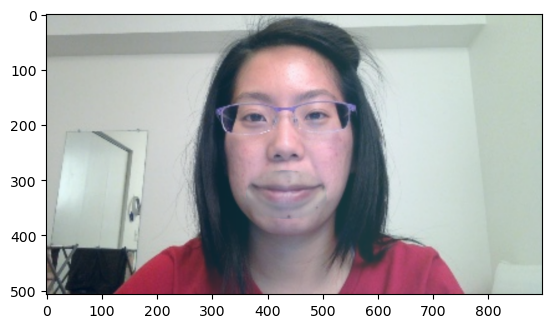

In [12]:
destination = image1.astype(np.float32)
source = image1_result.astype(np.float32)
mask_from_source = mask1.astype(np.float32)
output = colorBlending(source, destination, mask_from_source)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output_rgb.astype(int));

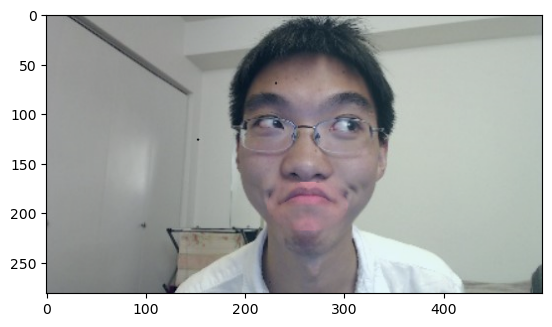

In [13]:
destination = image2.astype(np.float32)
source = image2_result.astype(np.float32)
mask_from_source = mask2.astype(np.float32)
output = colorBlending(source, destination, mask_from_source)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output_rgb.astype(int));

